<h1>RNN - LSTM x GRU</h1>
<p>O objetivo deste código é apresentar um exemplo simples de aplicação de redes neurais recorrentes (RNN) para a análise de textos (NLP). Neste caso, vamos aplicar deep learning para obter a partir do comentário realizado a cerca de um deteminado filme se este comentário foi ou não positivo. Os dados foram retirados do IMDB, e cujo link segue abaixo: </p>
<p><a href="https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences">Dados de comentários sobre IMDB</a></p>

<p>Vale observar que como são dados utilizados justamente para testes então eles costumam vir já pré-processados de maneira que não é necessário fazer limpezas nos comentários, excluindo por exmeplo caracteres errados ou símbolos. O que será feito é justamente o procedimento de tokenização para depois aplicar os métodos de LSTM e GRU. </p>

<h3>Importando Pacotes</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation,SpatialDropout1D,Embedding,LSTM,GRU
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


<h3>Importando dados do IMDB</h3>

In [2]:
df = pd.read_table('imdb.txt', header=0)
df.head()

/home/novais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,msg,positive
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [3]:
#Informações sobre a base de dados:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
msg         748 non-null object
positive    748 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [4]:
#Exemplo de comentário feito sobre um filme:
df.msg[5]

"The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.  "

In [5]:
#Distribuição de filmes avalidados positivamente(1) e negativamente(0)
df['positive'].value_counts()

1    386
0    362
Name: positive, dtype: int64

<h3>Tratando comentários</h3>

In [6]:
#Variáveis para o procedimento de Tokenização:
numero_maximo_palavras = 1000
sequencia_maxima_palavras = 100
dimensao = 100

In [7]:
#Tokenizando:
tokenizer = Tokenizer(num_words=numero_maximo_palavras, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['msg'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3236 unique tokens.


In [8]:
#Verificando o shape do Tensor:
X = tokenizer.texts_to_sequences(df['msg'].values)
X = pad_sequences(X, maxlen=sequencia_maxima_palavras)
Y = df['positive'].values
print('Shape of data tensor:', X.shape)

Shape of data tensor: (748, 100)


<h3>Preparando dados de Treino e Teste</h3>

In [9]:
#test_size:
ts = 0.20
#random_state:
rs = 100
#Separando os dados de treino e teste:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = ts,random_state = rs)
#Printando resultados:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(598, 100) (598,)
(150, 100) (150,)


<h3>Rodando os modelos</h3>

In [10]:
#Parâmetros:
epochs = 20
batch_size = 10
patience = 3
vs=0.1
md = 0.0001
monitor = 'val_loss'

In [17]:
%%capture --no-stdout
#Modelo LSTM:
modelLSTM = Sequential()
modelLSTM.add(Embedding(numero_maximo_palavras, dimensao, input_length=X.shape[1]))
modelLSTM.add(SpatialDropout1D(0.1))
modelLSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modelLSTM.add(Dense(1, activation='relu'))
modelLSTM.add(Dense(1, activation='relu'))
modelLSTM.add(Dense(1, activation='relu'))
modelLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
#Aprendizado LSTM:
historyLSTM = modelLSTM.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=vs,callbacks=[EarlyStopping(monitor=monitor, patience=patience, min_delta=md)])

Train on 538 samples, validate on 60 samples
Epoch 1/20
538/538 [==============================] - 9s 17ms/step - loss: 1.1537 - acc: 0.4796 - val_loss: 0.7202 - val_acc: 0.4667
Epoch 2/20
538/538 [==============================] - 6s 12ms/step - loss: 0.6689 - acc: 0.5688 - val_loss: 0.6534 - val_acc: 0.7167
Epoch 3/20
538/538 [==============================] - 6s 12ms/step - loss: 0.5582 - acc: 0.7565 - val_loss: 0.5460 - val_acc: 0.7000
Epoch 4/20
538/538 [==============================] - 6s 12ms/step - loss: 0.3709 - acc: 0.8662 - val_loss: 0.7682 - val_acc: 0.7167
Epoch 5/20
538/538 [==============================] - 6s 12ms/step - loss: 0.2534 - acc: 0.8197 - val_loss: 0.8059 - val_acc: 0.6833
Epoch 6/20
538/538 [==============================] - 6s 12ms/step - loss: 0.1797 - acc: 0.6952 - val_loss: 1.0700 - val_acc: 0.6667


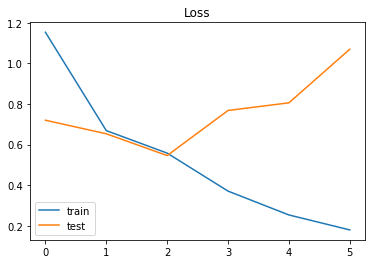

In [14]:
#Curva de Loss do treino e do teste:
plt.title('Loss')
plt.plot(historyLSTM.history['loss'], label='train')
plt.plot(historyLSTM.history['val_loss'], label='test')
plt.legend()
plt.show();

In [29]:
#Parâmetros:
epochs = 15
batch_size = 10
patience = 3
vs=0.1
md = 0.0001
monitor = 'val_loss'

In [30]:
%%capture --no-stdout
#Modelo GRU:
modelGRU = Sequential()
modelGRU.add(Embedding(numero_maximo_palavras, dimensao, input_length=X.shape[1]))
modelGRU.add(SpatialDropout1D(0.1))
modelGRU.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelGRU.add(Dense(1, activation='relu'))
modelGRU.add(Dense(1, activation='relu'))
modelGRU.add(Dense(1, activation='relu'))
modelGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
#Aprendizado GRU:
historyGRU = modelGRU.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=vs,callbacks=[EarlyStopping(monitor=monitor, patience=patience, min_delta=md)])

Train on 538 samples, validate on 60 samples
Epoch 1/15
538/538 [==============================] - 9s 16ms/step - loss: 0.8883 - acc: 0.5353 - val_loss: 0.6390 - val_acc: 0.6500
Epoch 2/15
538/538 [==============================] - 5s 10ms/step - loss: 0.5269 - acc: 0.7732 - val_loss: 0.5527 - val_acc: 0.7667
Epoch 3/15
538/538 [==============================] - 6s 11ms/step - loss: 0.3637 - acc: 0.8717 - val_loss: 0.5968 - val_acc: 0.7500
Epoch 4/15
538/538 [==============================] - 6s 11ms/step - loss: 0.1923 - acc: 0.8401 - val_loss: 1.1242 - val_acc: 0.6667
Epoch 5/15
538/538 [==============================] - 6s 10ms/step - loss: 0.1431 - acc: 0.7825 - val_loss: 1.4650 - val_acc: 0.6000


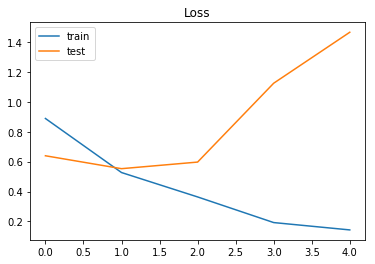

In [32]:
#Curva de Loss do treino e do teste:
plt.title('Loss')
plt.plot(historyGRU.history['loss'], label='train')
plt.plot(historyGRU.history['val_loss'], label='test')
plt.legend()
plt.show();